In [ ]:
# ==============================
# 1. โหลดข้อมูลจาก Kaggle (ไม่ใช้ Google Drive)
# ==============================

# ถ้ายังไม่ได้ติดตั้ง (รันครั้งเดียว)
# !pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# โหลด Dataset Credit Card Fraud 2023 จาก Kaggle
df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "nelgiriyewithana/credit-card-fraud-detection-dataset-2023",
    "creditcard_2023.csv"
)

# ตรวจสอบข้อมูล
print(df.shape)

print("Original class distribution:")
print(df['Class'].value_counts(normalize=True))


Using Colab cache for faster access to the 'credit-card-fraud-detection-dataset-2023' dataset.
(568630, 31)
Original class distribution:
Class
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# ==============================
# 2. จำลอง Imbalanced Data (Fraud ≈ 5%)
# ==============================

# แยกข้อมูลคลาสปกติ (Non-Fraud: Class = 0)
# ใช้เป็นคลาสส่วนใหญ่ (Majority Class)
df_majority = df[df['Class'] == 0]

# แยกข้อมูลคลาสทุจริต (Fraud: Class = 1)
# ใช้เป็นคลาสส่วนน้อย (Minority Class)
df_minority = df[df['Class'] == 1]

# ลดจำนวนข้อมูล Fraud ลงให้เหลือประมาณ 5%
# เพื่อจำลองสถานการณ์จริงที่การทุจริตเกิดขึ้นน้อยมาก
df_minority_down = df_minority.sample(
    frac=0.05,          # เลือกมาเพียง 5% ของข้อมูล Fraud
    random_state=42     # กำหนดค่า seed เพื่อให้สุ่มซ้ำได้ผลเหมือนเดิม
)

# รวมข้อมูล Majority (Class=0) กับ Minority ที่ถูกลดจำนวนแล้ว
# จะได้ชุดข้อมูลที่มีความไม่สมดุลของคลาส (Imbalanced Data)
df_imbalanced = pd.concat([df_majority, df_minority_down])

#ตรวจสอบสัดส่วนคลาสหลังจำลอง Imbalanced Data

print("\nAfter making imbalanced:")

# แสดงจำนวนข้อมูลของแต่ละคลาส
print(df_imbalanced['Class'].value_counts())

# แสดงสัดส่วนของแต่ละคลาส (เป็นเปอร์เซ็นต์)
print(df_imbalanced['Class'].value_counts(normalize=True))



After making imbalanced:
Class
0    284315
1     14216
Name: count, dtype: int64
Class
0    0.95238
1    0.04762
Name: proportion, dtype: float64


In [ ]:
# ==============================
# 3. แยกข้อมูลเป็น Features และ Target + Train/Test Split
# ==============================

# กำหนดชื่อคอลัมน์เป้าหมาย (Target Variable)
TARGET = 'Class'

# แยก Feature (X)
# ลบคอลัมน์ที่ไม่ควรใช้ในการเรียนรู้โมเดล
# - id : เป็นเพียงรหัส ไม่เกี่ยวกับพฤติกรรมธุรกรรม
# - Class : เป็น label (ห้ามใช้เป็น feature)
X = df_imbalanced.drop(columns=['id', TARGET])

# แยก Target (y)
y = df_imbalanced[TARGET]

# แบ่งข้อมูลเป็น Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # ใช้ข้อมูล 20% เป็นชุดทดสอบ
    random_state=42,      # กำหนด seed เพื่อให้ได้ผลลัพธ์ซ้ำได้
    stratify=y            # รักษาสัดส่วนคลาสใน train/test ให้เหมือนกัน
)


In [ ]:
# ==============================
# 4. ใช้ SMOTE แก้ปัญหา Imbalanced Data (เฉพาะชุด Train)
# ==============================

# สร้างอ็อบเจกต์ SMOTE
# SMOTE (Synthetic Minority Over-sampling Technique)
# ใช้สร้างข้อมูลเทียมของคลาสส่วนน้อย (Fraud)
# เพื่อให้โมเดลเรียนรู้รูปแบบของ Fraud ได้ดีขึ้น
smote = SMOTE(random_state=42)

# ใช้ SMOTE กับชุดข้อมูลฝึก (Train) เท่านั้น
# ❗ ห้ามใช้กับ Test เพราะจะทำให้เกิด Data Leakage
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# ตรวจสอบผลก่อนและหลังใช้ SMOTE
print("\nBefore SMOTE (Train):")
# แสดงจำนวนข้อมูลของแต่ละคลาสก่อนใช้ SMOTE
print(y_train.value_counts())

print("\nAfter SMOTE (Train):")
# แสดงจำนวนข้อมูลของแต่ละคลาสหลังใช้ SMOTE
# จะเห็นว่าจำนวน Fraud (Class=1) เพิ่มขึ้นจนสมดุลกับ Class=0
print(pd.Series(y_train_sm).value_counts())



Before SMOTE (Train):
Class
0    227451
1     11373
Name: count, dtype: int64

After SMOTE (Train):
Class
0    227451
1    227451
Name: count, dtype: int64


Logistic ROC-AUC: 0.9935133411477132


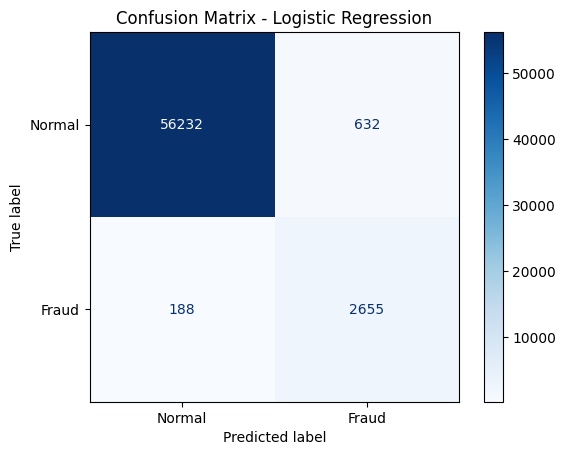


Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.81      0.93      0.87      2843

    accuracy                           0.99     59707
   macro avg       0.90      0.96      0.93     59707
weighted avg       0.99      0.99      0.99     59707



In [ ]:
# ==============================
# 5. สร้างและฝึก Logistic Regression (พร้อม Feature Scaling)
# ==============================

# สร้าง Pipeline เพื่อรวมขั้นตอนการปรับสเกลข้อมูลและการฝึกโมเดล
# - StandardScaler: ปรับข้อมูลให้อยู่ในช่วงมาตรฐาน (mean=0, std=1)
# - LogisticRegression: โมเดลเชิงเส้นสำหรับงาน Classification
log_model = Pipeline([
    ('scaler', StandardScaler()),   # ปรับสเกล feature (จำเป็นสำหรับ Logistic)
    ('logreg', LogisticRegression(
        max_iter=3000,               # เพิ่มจำนวนรอบ เพื่อให้โมเดล converge
        solver='lbfgs'               # solver มาตรฐานสำหรับ Logistic Regression
    ))
])

# ฝึกโมเดลด้วยชุดข้อมูล Train หลังจากผ่านการใช้ SMOTE แล้ว
log_model.fit(X_train_sm, y_train_sm)

# ==============================
# 5.1 การประเมินผลด้วย ROC-AUC
# ==============================

# ทำนายความน่าจะเป็นของการเป็น Fraud (Class=1)
# ใช้ predict_proba เพื่อรองรับการคำนวณ ROC-AUC
y_pred_log = log_model.predict_proba(X_test)[:, 1]

# คำนวณค่า ROC-AUC บนชุด Test
roc_log = roc_auc_score(y_test, y_pred_log)

# แสดงผลลัพธ์
print("Logistic ROC-AUC:", roc_log)

# ==============================
# 5.2 Confusion Matrix สำหรับ Logistic Regression
# ==============================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# แปลงค่าความน่าจะเป็นเป็นคลาส (Threshold = 0.5)
y_pred_log_label = (y_pred_log >= 0.5).astype(int)

# คำนวณ Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log_label)

# แสดง Confusion Matrix
disp_log = ConfusionMatrixDisplay(
    confusion_matrix=cm_log,
    display_labels=["Normal", "Fraud"]
)

disp_log.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()

# รายงาน Precision, Recall, F1-score
print("\nClassification Report - Logistic Regression")
print(classification_report(y_test, y_pred_log_label))


Random Forest ROC-AUC: 0.9964620771807504


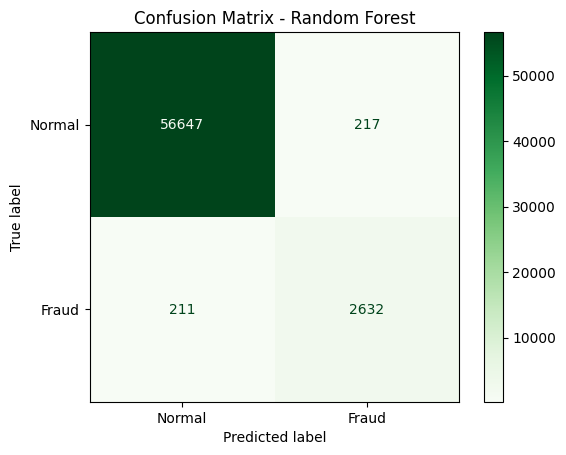


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.93      0.92      2843

    accuracy                           0.99     59707
   macro avg       0.96      0.96      0.96     59707
weighted avg       0.99      0.99      0.99     59707



In [ ]:
# ==============================
# 6. Random Forest Classifier
# ==============================

# สร้างโมเดล Random Forest
# Random Forest เป็นโมเดลแบบ Ensemble
# ใช้การรวมผลจากต้นไม้หลายต้น (Decision Trees)
# เหมาะกับข้อมูลที่มีความซับซ้อนและไม่เป็นเชิงเส้น
rf_model = RandomForestClassifier(
    n_estimators=50,        # จำนวนต้นไม้ (ยิ่งมากยิ่งแม่น แต่ใช้เวลามากขึ้น)
    max_depth=8,            # จำกัดความลึกของต้นไม้ เพื่อลด Overfitting
    min_samples_split=10,   # จำนวนข้อมูลขั้นต่ำในการแยก node
    n_jobs=-1,              # ใช้ทุก core ของ CPU (เหมาะกับ Colab)
    random_state=42         # เพื่อให้ผลลัพธ์ reproducible
)

# ฝึกโมเดลด้วยชุด Train หลังจากผ่าน SMOTE
# (เฉพาะ Train เท่านั้น เพื่อป้องกัน Data Leakage)
rf_model.fit(X_train_sm, y_train_sm)


# ==============================
# 6.1 ประเมินประสิทธิภาพด้วย ROC-AUC
# ==============================

# ทำนายความน่าจะเป็นของการเป็น Fraud (Class = 1)
y_pred_rf = rf_model.predict_proba(X_test)[:, 1]

# คำนวณค่า ROC-AUC บนชุด Test
roc_rf = roc_auc_score(y_test, y_pred_rf)

# แสดงผลลัพธ์
print("Random Forest ROC-AUC:", roc_rf)


# ==============================
# 6.2 Confusion Matrix สำหรับ Random Forest
# ==============================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# แปลงค่าความน่าจะเป็นเป็นคลาส (Threshold = 0.5)
y_pred_rf_label = (y_pred_rf >= 0.5).astype(int)

# คำนวณ Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf_label)

# แสดง Confusion Matrix
disp_rf = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Normal", "Fraud"]
)

disp_rf.plot(cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

# แสดง Precision, Recall, F1-score
print("\nClassification Report - Random Forest")
print(classification_report(y_test, y_pred_rf_label))


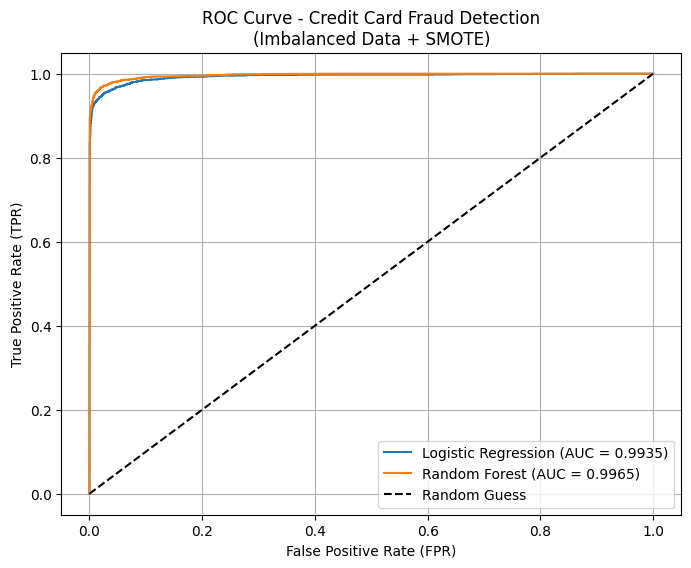

In [ ]:
# ==============================
# 7. วาดกราฟ ROC Curve
# ==============================

# คำนวณค่า False Positive Rate (FPR) และ True Positive Rate (TPR)
# สำหรับ Logistic Regression
# roc_curve จะคืนค่า:
# - FPR: อัตราการทำนายผิดว่าเป็น Fraud (False Alarm)
# - TPR: อัตราการตรวจจับ Fraud ได้ถูกต้อง (Recall)
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log)

# คำนวณค่า FPR และ TPR สำหรับ Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)


# ==============================
# สร้างกราฟ ROC
# ==============================

plt.figure(figsize=(8,6))

# วาด ROC Curve ของ Logistic Regression
# พร้อมแสดงค่า AUC ใน legend
plt.plot(
    fpr_log,
    tpr_log,
    label=f'Logistic Regression (AUC = {roc_log:.4f})'
)

# วาด ROC Curve ของ Random Forest
plt.plot(
    fpr_rf,
    tpr_rf,
    label=f'Random Forest (AUC = {roc_rf:.4f})'
)

# เส้นทแยงมุม (Baseline)
# แสดงผลของโมเดลที่ทำนายแบบสุ่ม
plt.plot([0,1], [0,1], 'k--', label='Random Guess')

# กำหนดชื่อแกน X และ Y
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")

# ชื่อกราฟ
plt.title("ROC Curve - Credit Card Fraud Detection\n(Imbalanced Data + SMOTE)")

# แสดง legend
plt.legend()

# แสดง grid เพื่อให้อ่านค่าได้ง่าย
plt.grid()

# แสดงกราฟ
plt.show()
